# TSP Belgium

### summary 

finds the shortest route between all the 581 municipalities (gemeentes) in Belgium

"as the crow flies" / "in vogelvlucht"

the dataset was gathered and processed in a different notebook

The result is a walk of distance: 3931.12 km

If we were using not only all municipalities but also all villages (gemeentes/ deelgemeentes),
it would be more complex to create a proper dataset.
The dataset would amount to around 3000 places 
which would make the christofides algorithm run for several hours on my machine
and would result in a walk of over 10000km

next steps:
- use distance by walking paths as weights in calculation in stead of the straight line
- make dataset of all villages

In [ ]:
!pip3 install networkx matplotlib numpy geopy folium

In [15]:
# Import required libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic
import json
import folium

## helper functions

In [3]:
def getTestData(feature_collection, amount):
    subset_features = feature_collection['features'][:amount]
    feature_collection = {
        "type": "FeatureCollection",
        "features": subset_features
    }
    return feature_collection


# Function to calculate distances between points
def calculate_distance(coord1, coord2):
    return geodesic(coord1, coord2).kilometers

## load data

In [4]:
# Path to the GeoJSON file
filename = 'gemeentes.geojson'

# Read the GeoJSON file
with open(filename, 'r') as file:
    feature_collection = json.load(file)

# Print the number of features
num_features = len(feature_collection['features'])
print("Number of features:", num_features)

Number of features: 581


## show on map

In [29]:
m = folium.Map(location=[50.55, 4.34878], zoom_start=8)

# Function to add red circles
def add_circles(map_object, data):
    for feature in data['features']:
        if feature['geometry']['type'] == 'Point':
            coords = feature['geometry']['coordinates']
            name = feature['properties'].get('name', 'No Name')  # Default to 'No Name' if none found
            tooltip = folium.Tooltip(f"{name}", permanent=False)
            folium.CircleMarker(
                location=[coords[1], coords[0]],
                radius=5,
                color='red',
                fill=True,
                fill_color='red',
                fill_opacity=0.7,
                tooltip=tooltip
            ).add_to(map_object)

# Apply the function to add circles
add_circles(m, feature_collection)


folium.LayerControl().add_to(m)

# Display the map
m

## create graph

In [5]:
# Create a graph
G = nx.Graph()

In [6]:
# Prepare nodes and add them to the graph
nodes = []
for feature in feature_collection['features']:
    name = feature['properties']['name']
    coords = tuple(feature['geometry']['coordinates'][::-1]) # Reverse to (lat, lon)
    nodes.append((name, coords))
    G.add_node(name, coordinates=coords)

581 nodes = 15s

1000 nodes = 44s

2000 nodes = 180s

3363 nodes = 8m29s

In [7]:
# Add edges with distances as weights
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        node1_name, node1_coords = nodes[i]
        node2_name, node2_coords = nodes[j]
        distance = calculate_distance(node1_coords, node2_coords)
        G.add_edge(node1_name, node2_name, weight=distance)

## solve TSP

In [8]:
# greedy algorithm

def getGreedyRoute(start_node):
    if start_node in G:
        tsp_route = nx.approximation.greedy_tsp(G, source=start_node, weight='weight')
        print("TSP Route starting from", start_node, ":", tsp_route)
    else:
        print(start_node, "not found in the data")
        
#tsp_route = getGreedyRoute("Hove")

581 nodes = 6.6s

In [9]:
# Christofides

#tsp_route = nx.approximation.traveling_salesman_problem(G, method='christofides', weight='weight')
tsp_route = nx.approximation.christofides(G, weight='weight')

In [ ]:
# Starting node, if specific start is needed
start_node = 'Hove'  

# Check if the starting node exists in the graph
if start_node in G:
    
    # Rotate the tour to start at 'Hove'
    start_index = tsp_route.index(start_node)
    rotated_tsp_route = tsp_route[start_index:] + tsp_route[:start_index]
    tsp_route = rotated_tsp_route
    
    print("TSP Route using Christofides algorithm starting from", start_node, ":", tsp_route)
else:
    print(start_node, "not found in the data")

## plot result

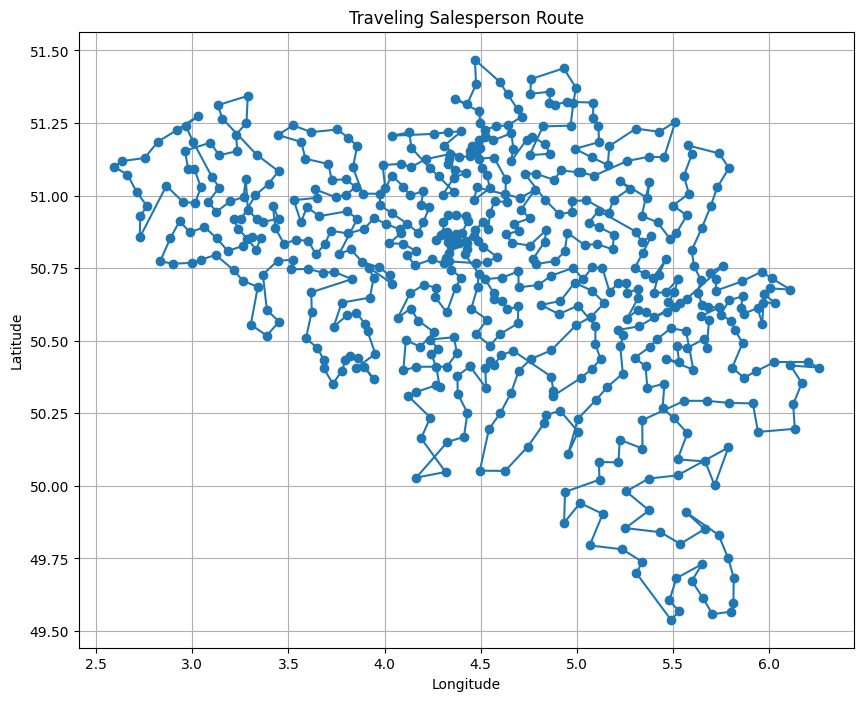

In [11]:
# Plotting the route
coords = {feature['properties']['name']: tuple(feature['geometry']['coordinates'][::-1]) for feature in feature_collection['features']}
route_coords = [coords[place] for place in tsp_route]

# Unpack coordinates for plotting
lats, lons = zip(*route_coords)

plt.figure(figsize=(10, 8))
plt.plot(lons, lats, 'o-')  # Plot points with lines between them

# for i, txt in enumerate(tsp_route):
#     plt.annotate(txt, (lons[i], lats[i]))

plt.title('Traveling Salesperson Route')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

## output routes

In [12]:
# Prepare to list the route with distances
route_with_distances = []

previous_place = None
total_distance = 0

# Iterate through the route
for place in tsp_route:
    if previous_place is not None:
        # Get coordinates
        coord1 = coords[previous_place]
        coord2 = coords[place]

        # Calculate distance
        distance = calculate_distance(coord1, coord2)
        total_distance += distance

        # Append to the route list
        route_with_distances.append({
            "from": previous_place,
            "to": place,
            "distance": f"{distance:.2f} km"
        })
    
    previous_place = place

# Optionally, to make the route circular
if len(tsp_route) > 1:
    first_place = tsp_route[0]
    last_place = tsp_route[-1]
    coord1 = coords[last_place]
    coord2 = coords[first_place]
    distance = calculate_distance(coord1, coord2)
    total_distance += distance
    route_with_distances.append({
        "from": last_place,
        "to": first_place,
        "distance": f"{distance:.2f} km"
    })

# Print the route with distances
for leg in route_with_distances:
    print(f"{leg['from']} -> {leg['to']} = {leg['distance']}")

# Print total distance
print(f"Total distance: {total_distance:.2f} km")


Hove -> Duffel = 6.22 km
Duffel -> Sint-Katelijne-Waver = 3.40 km
Sint-Katelijne-Waver -> Bonheiden = 5.09 km
Bonheiden -> Zemst = 7.42 km
Zemst -> Mechelen = 5.00 km
Mechelen -> Tremelo = 16.21 km
Tremelo -> Begijnendijk = 6.28 km
Begijnendijk -> Rotselaar = 9.12 km
Rotselaar -> Holsbeek = 4.72 km
Holsbeek -> Herent = 6.28 km
Herent -> Leuven = 3.31 km
Leuven -> Bertem = 5.18 km
Bertem -> Oud-Heverlee = 3.89 km
Oud-Heverlee -> Bierbeek = 6.53 km
Bierbeek -> Lubbeek = 8.57 km
Lubbeek -> Boutersem = 4.67 km
Boutersem -> Beauvechain = 7.83 km
Beauvechain -> La Bruyère = 2.16 km
La Bruyère -> Hoegaarden = 7.06 km
Hoegaarden -> Tienen = 5.12 km
Tienen -> Glabbeek = 7.29 km
Glabbeek -> Linter = 7.94 km
Linter -> Zoutleeuw = 4.40 km
Zoutleeuw -> Sint-Truiden = 6.16 km
Sint-Truiden -> Nieuwerkerken = 5.60 km
Nieuwerkerken -> Geetbets = 6.32 km
Geetbets -> Kortenaken = 4.02 km
Kortenaken -> Halen = 5.87 km
Halen -> Alken = 15.83 km
Alken -> Wellen = 4.30 km
Wellen -> Kortessem = 4.05 km
Kortes